# 최대 샤프비율 포트폴리오 (MSR Portfolio)

지난 시간에 우리는 기대 수익률과 공분산 행렬이 주어졌을 때 효율적 경계선을 그릴 수 있다는 것을 확인했습니다. 이번 시간에는 효율적 경계선에 접선인 포트폴리오, 즉 샤프비율이 최대가 되는 포트폴리오를 찾기 위해 소스코드를 확장해보겠습니다. 샤프비율이 최대가 되는 포트폴리오는 변동성 대비 수익률을 극대화할 수 있는 포트폴리오이기 때문에 우리가 가장 관심있어하는 포트폴리오입니다.

언제나 그랬듯이 데이터셋을 가져오는 것으로부터 시작을 해보겠습니다.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import port_opt_toolkit as potk

ind = potk.get_ind_returns()
er = potk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

우리는 이미 목표 수익률이 주어질 때 효율적 경계선의 점을 식별하는 방법을 알고 있습니다. 이번 세션에서 우리의 목표는 목표 수익률이 주어졌을 때 변동성을 최소화하는 것 대신, 무위험 금리가 주어지면 효율적 경계선에서 샤프 비율을 최대화할 수 있는 한 지점을 찾는 것입니다.

```python
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
```

그 포인트가 어딘지 한 번 찾아보겠습니다.

(0.0, 0.1417850347867131)

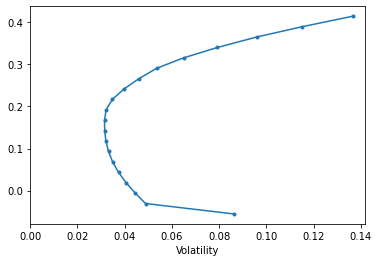

In [2]:
ax = potk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

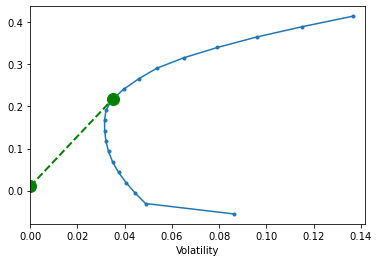

In [4]:
# plot EF
ax = potk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.01
w_msr = potk.msr(rf, er, cov)
r_msr = potk.portfolio_return(w_msr, er)
vol_msr = potk.portfolio_vol(w_msr, cov)
# add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [5]:
r_msr, vol_msr

(0.21898433493416328, 0.035141634948168694)

`plot_ef` 코드에 자본시장선(CML, Capital Market Line)을 추가하여 모든 것을 하나로 통합해 보겠습니다.

```python
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
```

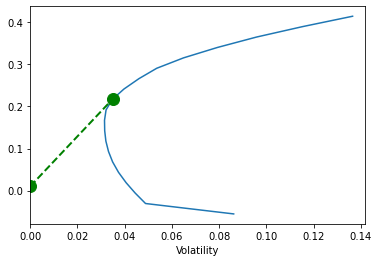

In [7]:
potk.plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.01)